<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot basado en reglas con DNN + Spacy

#### Datos
Este ejemplo se inspiró en otro Bot en inglés creado con NLTK, lo tienen como referencia para hacer lo mismo en inglés:\
[LINK](https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758)

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [1]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pepiline nlp transformers
!pip install -U spacy==3.1 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

In [2]:
import json
import string
import random 
import numpy as np

import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

import nltk
import numpy as np
from nltk.stem import WordNetLemmatizer

In [3]:
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to /Users/marcosb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/marcosb/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [4]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):    
    # sacar tildes de las palabras:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # [^ : ningún caracter de todos estos
    # (termina eliminando cualquier caracter distinto de los del regex)
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

### 3 - Diccionario de entrada

In [5]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
# Los "patterns" van a formar el corpus para entrenar el clasificador que clasifica en tags
# "respones" son las respuestas predeterminadas posibles para cada tag
dataset = {"intents": [
             {"tag": "greeting",
              "patterns": ["Hello", "How are you?", "Hi there", "Hi", "Whats up"],
              "responses": ["Howdy!", "Hello", "How are you doing?", "Greetings!", "How do you do?"],
             },
             {"tag": "power_on_light",
              "patterns": ["power on the light", "turn on the light", "Light it up", "Turn on the light, please.", "Start the lights"],
              "responses": ["Turning on bedroom light."]
             },
             {"tag": "power_off_light",
              "patterns": ["power off the light", "turn off the light", "want to sleep", "Shut down the lights", "Stop the lights, please"],
              "responses": ["Turning off bedroom light."]
             },
             {"tag": "start_music",
              "patterns": ["Play some music", "Start the radio", "Start playing music", "Put some songs"],
              "responses": ["Playing some music now."]
             },
             {"tag": "stop_music",
              "patterns": ["Stop the music", "Shut down the radio", "Stop playing music", "Turn down the volume."],
              "responses": ["Stoping the music"]
             },
             {"tag": "get_weather",
              "patterns": ["What's the weather like today?", "How's the weather?", "What's the temperature today?", "What's the weather forecast?"],
              "responses": ["This is the weather forecast for today: \n 24°C Cloudy"]
             }
]}

### 4 - Preprocesamiento y armado del dataset

In [6]:
# Datos que necesitaremos, las palabras o vocabulario
words = []      # Mi diccionario
classes = []    # Las classes (tags)
doc_X = []
doc_y = []

lemmatizer = WordNetLemmatizer()

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para almacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)
# En `words` vamos a guardar el vocabulario
# En `class` las posibles clases o tags
for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        tokens = nltk.word_tokenize(pattern)
        words.extend(tokens)
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # add the tag to the classes if it's not there already 
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# lemmatize all the words in the vocab and convert them to lowercase
# if the words don't appear in punctuation
words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in string.punctuation]

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [7]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ["'s", 'are', 'down', 'forecast', 'hello', 'hi', 'how', 'light', 'like', 'lumus', 'music', 'off', 'on', 'play', 'playing', 'power', 'put', 'radio', 'shut', 'sleep', 'some', 'song', 'start', 'stop', 'temperature', 'the', 'there', 'to', 'today', 'turn', 'up', 'volume', 'want', 'weather', 'what', 'whats', 'you']
classes: ['get_weather', 'greeting', 'power_off_light', 'power_on_light', 'start_music', 'stop_music']
doc_X: ['Hello', 'How are you?', 'Hi there', 'Hi', 'Whats up', 'power on the light', 'turn on the light', 'lumus', 'power off the light', 'turn off the light', 'want to sleep', 'Play some music', 'Start the radio', 'Start playing music', 'Put some songs', 'Stop the music', 'Shut down the radio', 'Stop playing music', 'Turn down the volume.', "What's the weather like today?", "How's the weather?", "What's the temperature today?", "What's the weather forecast?"]
doc_y: ['greeting', 'greeting', 'greeting', 'greeting', 'greeting', 'power_on_light', 'power_on_light', 'power_on_

In [8]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 37


In [9]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 6


In [10]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)
n_docsx = len(doc_X)
n_words = len(words)
print(f'n_docsX={n_docsx} | n_words={n_words}')

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nltk.word_tokenize(doc.lower())
    for token in tokens:
        text.append(lemmatizer.lemmatize(token))

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for w_idx, word in enumerate(words):
        bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

n_docsX=23 | n_words=37
X: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0]
X: [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] y: [0, 1, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0] y: [0, 1, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 1, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 1, 0, 0]
X: [0, 0, 0, 0, 0

### 5 - Entrenamiento del modelo

In [11]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (37,) output: 6


In [12]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               4864      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 13,510
Trainable params: 13,510
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200


2023-03-18 19:24:56.028033: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 186ms/step - loss: 1.8641 - accuracy: 0.1739
Epoch 2/200
1/1 [==============================] - 0s 1ms/step - loss: 1.8433 - accuracy: 0.1304
Epoch 3/200
1/1 [==============================] - 0s 1ms/step - loss: 1.8247 - accuracy: 0.1304
Epoch 4/200
1/1 [==============================] - 0s 2ms/step - loss: 1.7268 - accuracy: 0.4348
Epoch 5/200
1/1 [==============================] - 0s 2ms/step - loss: 1.7629 - accuracy: 0.2609
Epoch 6/200
1/1 [==============================] - 0s 2ms/step - loss: 1.7237 - accuracy: 0.3043
Epoch 7/200
1/1 [==============================] - 0s 2ms/step - loss: 1.7065 - accuracy: 0.2174
Epoch 8/200
1/1 [==============================] - 0s 2ms/step - loss: 1.7498 - accuracy: 0.3478
Epoch 9/200
1/1 [==============================] - 0s 2ms/step - loss: 1.8113 - accuracy: 0.1739
Epoch 10/200
1/1 [==============================] - 0s 2ms/step - loss: 1.6093 - accuracy: 0.5652
Epoch 11/200
1/1 [=====================

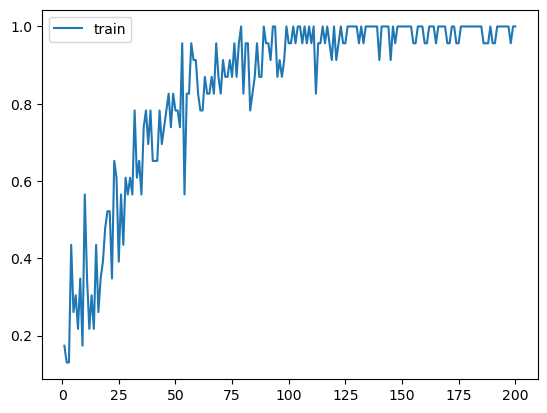

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [17]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

### 6 - Testing y validación

In [20]:
# convertir texto de entrada del usuario a tokens
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nltk.word_tokenize(text.lower())
    for token in tokens:
        lemma_tokens.append(lemmatizer.lemmatize(token))
    #print(lemma_tokens)
    return lemma_tokens

# transformar el texto de entrada tokenizado a una representación OHE
def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

# usar modelo con la entrada en OHE y los labels posibles (tags)
def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0: # sólo si reconoció alguna palabra del vocabulario
        result = model.predict(np.array([bow]))[0] # es un array de softmax
        thresh = 0.2
        # filtrar aquellas entradas menores al umbral `thresh`
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # ordenar keys de acuerdo al valor softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        # return_list es una lista de los labels de mayor a menor
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    # si no reconoció palabras del vocabulario se devuelve una lista vacía
    return return_list

# obtener una respuesta predeterminada 
def get_response(intents_list, intents_json):
    tag = intents_list[0] # tomar el tag con el mejor valor softmax
    list_of_intents = intents_json["intents"] # intents_json es todo el dataset
    for i in list_of_intents: 
        if i["tag"] == tag: # buscar el tag correspoindiente y dar una respuesta predeterminada aleatoria 
            result = random.choice(i["responses"])
            break
    return result

In [24]:
import gradio as gr

def bot_response(human_text):
    print("Q:", human_text)    
    intents = pred_class(human_text, words, classes)
    if len(intents) > 0:
        resp = get_response(intents, dataset)
    else: # si no hubo ningún resultado que supere el umbral
        resp = "Sorry, I didn't understand the question"
    print("A:", resp)
    return resp

iface = gr.Interface(
    fn=bot_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

/Users/marcosb/opt/miniconda3/envs/nlp_tensor/lib/python3.10/site-packages/gradio/deprecation.py:40: UserWarning: `layout` parameter is deprecated, and it has no effect
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Q: Lights on
1/1 [==============================] - 0s 15ms/step
A: Turning on bedroom light.
Q: Lights off
1/1 [==============================] - 0s 16ms/step
A: Turning off bedroom light.
Q: Music on
1/1 [==============================] - 0s 14ms/step
A: Turning on bedroom light.
Q: weather
1/1 [==============================] - 0s 15ms/step
A: This is the weather forecast for today: 
 24°C Cloudy
Q: Tell me the weather please
1/1 [==============================] - 0s 15ms/step
A: This is the weather forecast for today: 
 24°C Cloudy
Q: What will the weather be like?
1/1 [==============================] - 0s 15ms/step
A: This is the weather forecast for today: 
 24°C Cloudy
Q: stop the music
1/1 [==============================] - 0s 15ms/step
A: Stoping the music
Q: Shut down the music
1/1 [==============================] - 0s 15ms/step
A: Stoping the music
Q: Turn the music off
1/1 [==============================] - 0s 15ms/step
A: Stoping the music
Q: Volume down
1/1 [=============

## Conclusiones:

- El modelo actual no toma palabras clave y por eso confunde intenciones. Un ejemplo es Q: "Lights up" y el bot detecta la intención "greeting" (dado que contiene la frase "Whats up"). Debería descartar la intención "greeting" dado que la palabra clave en ese ejemplo es "lights". Esto probablemente funcionaría mejor si se usa TF-IDF en lugar de bag of words. 
- Algo similar ocurre cuando Q: "Music on", donde el bot identifica la intención de prender las luces. Esto se debe a que en el dataset de entrenamiento, hay más casos de ejemplo usando "on" para las luces, en lugar de para la música.
- Algunas mejoras que se podrían hacer:
    - Crear 2 redes independientes que permitan identificar de forma separada la acción y el objetivo. Esto es útil ya que la acción "encender" se puede decir de varias formas ("turn on", "start", etc) y se puede aplicar a distintos targets ("lights", "music", etc). Teniendo 2 redes, una para acciones y otra para objectivos, podríamos mejorar el entrenamiento y rendimiento general de nuestro bot.
    - Que descarte una intención si no hay suficiente información para entender que acción quiere hacer el usuario. Por ejemplo -> Q: "lights" devuelve R: "Turning on the bedroom light", y no debería ya que no especifqué el objetivo. Esto se podría hacer con la propuesta de 2 redes que mencioné en el punto de arriba y agregando un threshold para eliminar las salidas de la red que sean menor a un cierto intervalo de confianza (e.g. si la red tiene un 30% de que cree que es "lights" el objetivo, descartarlo y no hacer nada). 
    - Hacer que el bot pueda identificar cuartos para aplicar la acción (e.j. acción: encender la luz ; lugar: cuarto, living, cocina, etc...)
